In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np

In [2]:
df = pd.read_csv('dataset/Microsoft_Stock.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


In [4]:
df.tail()

,Date,Open,High,Low,Close,Volume
1506,3/25/2021 16:00:00,235.30,236.94,231.57,232.34,34061853
1507,3/26/2021 16:00:00,231.55,236.71,231.55,236.48,25479853
1508,3/29/2021 16:00:00,236.59,236.80,231.88,235.24,25227455
1509,3/30/2021 16:00:00,233.53,233.85,231.10,231.85,24792012
1510,3/31/2021 16:00:00,232.91,239.10,232.39,235.77,43623471


In [5]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [20]:
df.reset_index(inplace=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1511 non-null   int64  
 1   Date    1511 non-null   object 
 2   Open    1511 non-null   float64
 3   High    1511 non-null   float64
 4   Low     1511 non-null   float64
 5   Close   1511 non-null   float64
 6   Volume  1511 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 82.8+ KB


In [24]:
from datetime import datetime

# Parse the original date-time string
# Convert date_time column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract only the date part
df['Date'] = df['Date'].apply(lambda x: x.date())

In [17]:
series = df['Close']

In [174]:
# Parameters
window_size = 30
batch_size = 30

In [175]:
def windowed_dataset(series, window_size, batch_size):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    # dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [176]:
# Define the split time
split = 0.8

# Get the train set 
time_test = df.Date[:int(len(df.Date)*0.8)]
x_train = df.Close[:int(len(df.Date)*0.8)]

# Get the validation set
time_valid = df.Date[int(len(df.Date)*0.8):]
x_valid = df.Close[int(len(df.Date)*0.8):]

In [177]:
# x_train = x_train.values.reshape(-1,1)
# x_train

In [178]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(0,1))
# scaled_xtrain = scaler.fit_transform(x_train)

In [180]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size)

In [181]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model_tune.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 30, 1)             0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 30, 64)            8704      
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                      

In [182]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7* 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model_tune.compile(loss='MAE', optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=120, callbacks=[lr_schedule])

Epoch 1/120
40/40 [==============================] - 7s 21ms/step - loss: 84.6856 - lr: 1.0000e-07
Epoch 2/120
40/40 [==============================] - 1s 17ms/step - loss: 84.6855 - lr: 1.1220e-07
Epoch 3/120
40/40 [==============================] - 1s 18ms/step - loss: 84.6855 - lr: 1.2589e-07
Epoch 4/120
40/40 [==============================] - 1s 19ms/step - loss: 84.6854 - lr: 1.4125e-07
Epoch 5/120
40/40 [==============================] - 1s 21ms/step - loss: 84.6853 - lr: 1.5849e-07
Epoch 6/120
40/40 [==============================] - 1s 21ms/step - loss: 84.6853 - lr: 1.7783e-07
Epoch 7/120
40/40 [==============================] - 1s 19ms/step - loss: 84.6852 - lr: 1.9953e-07
Epoch 8/120
40/40 [==============================] - 1s 18ms/step - loss: 84.6851 - lr: 2.2387e-07
Epoch 9/120
40/40 [==============================] - 1s 19ms/step - loss: 84.6850 - lr: 2.5119e-07
Epoch 10/120
40/40 [==============================] - 1s 19ms/step - loss: 84.6849 - lr: 2.8184e-07
Epoch 11/

(1e-07, 0.1, 0.0, 100.0)

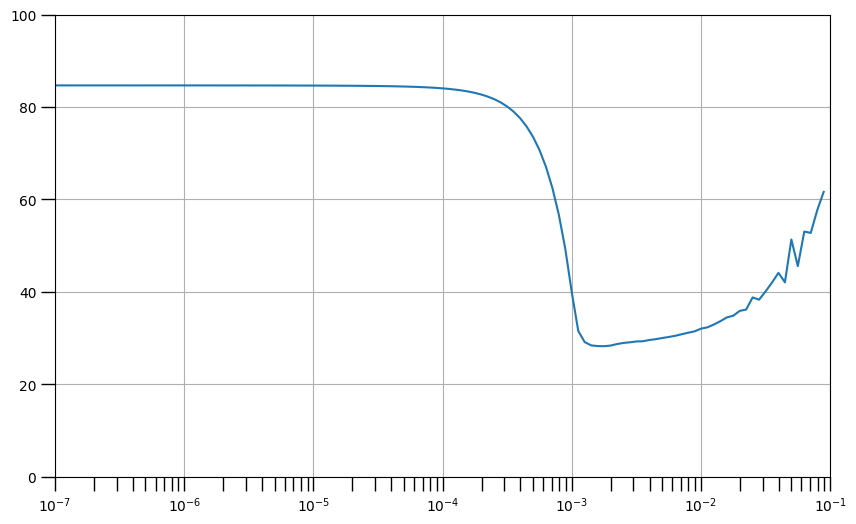

In [184]:
# Define the learning rate array
lrs = 1e-7 * (10 ** (np.arange(120) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-1, 0, 100])

In [193]:
from tensorflow.keras.callbacks import EarlyStopping

In [194]:
EarlyStop = EarlyStopping(monitor='loss',patience=10)

In [199]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 5e-2

# Set the optimizer 
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model.compile(loss='MAE', optimizer=optimizer,metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100,callbacks=[EarlyStop])

Epoch 1/100
40/40 [==============================] - 6s 24ms/step - loss: 84.4619 - mae: 84.4619
Epoch 2/100
40/40 [==============================] - 1s 18ms/step - loss: 83.7645 - mae: 83.7645
Epoch 3/100
40/40 [==============================] - 1s 18ms/step - loss: 82.6176 - mae: 82.6176
Epoch 4/100
40/40 [==============================] - 1s 19ms/step - loss: 80.9622 - mae: 80.9622
Epoch 5/100
40/40 [==============================] - 1s 18ms/step - loss: 78.7748 - mae: 78.7748
Epoch 6/100
40/40 [==============================] - 1s 19ms/step - loss: 76.0467 - mae: 76.0467
Epoch 7/100
40/40 [==============================] - 1s 19ms/step - loss: 72.7763 - mae: 72.7763
Epoch 8/100
40/40 [==============================] - 1s 19ms/step - loss: 68.9660 - mae: 68.9660
Epoch 9/100
40/40 [==============================] - 1s 20ms/step - loss: 64.6201 - mae: 64.6201
Epoch 10/100
40/40 [==============================] - 1s 21ms/step - loss: 59.7442 - mae: 59.7442
Epoch 11/100
40/40 [=========

In [186]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [200]:
# Reduce the original series
forecast_series = series[int(len(df.Date)*0.8)-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()


11/11 [==============================] - 1s 8ms/step


303

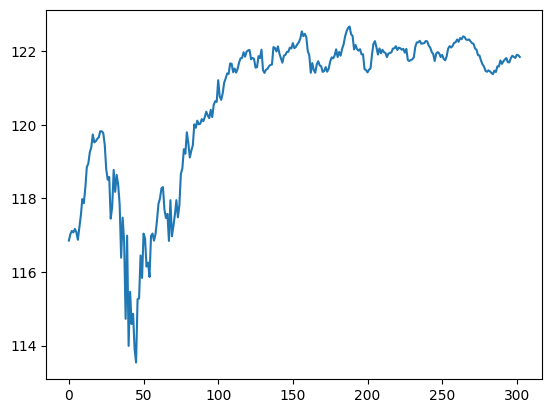

In [201]:
sns.lineplot(results)
len(results)

303

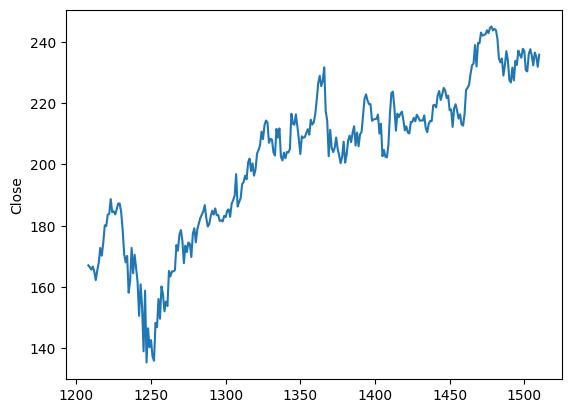

In [202]:
sns.lineplot(x_valid)
len(x_valid)